<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/angelo/AML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependency & DeepLab

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [1]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tqdm
import zipfile
import os

# ZIP files paths on Google Drive
zip_files = {
    "training": "/content/drive/My Drive/AML_project/Train.zip",
    "validation": "/content/drive/My Drive/AML_project/Val.zip",
    "test": "/content/drive/My Drive/AML_project/Test.zip"
}

# Destination directory on Colab
extract_path = "/content/dataset"

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)


for name, zip_path in zip_files.items():
    extract_dir = f"{extract_path}/{name}"

    # Check if the directory is non-empty (assumes extraction is complete if the folder has files)
    if os.path.exists(extract_dir) and any(os.scandir(extract_dir)):
        print(f"Skipping extraction for {name}, already extracted.")
    else:
        print(f"Extracting {name}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"{name} extracted!")

print("Extraction check completed!")

TRAINING_PATH_URBAN = os.path.join(extract_path, "training", "Train", "Urban")
TRAINING_PATH_RURAL = os.path.join(extract_path, "training", "Train", "Rural")
TEST_PATH_URBAN = os.path.join(extract_path, "test", "Test", "Urban")
TEST_PATH_RURAL = os.path.join(extract_path, "test", "Test", "Rural")
VAL_PATH_URBAN = os.path.join(extract_path, "validation", "Val", "Urban")
VAL_PATH_RURAL = os.path.join(extract_path, "validation", "Val", "Rural")

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extracting test...
test extracted!
Extraction check completed!


## Load DeepLab v2 PreTrained Weight

Crea la cartella model e inserisce il modello DeepLabv2


In [4]:
import requests
from pathlib import Path

models_dir = Path("models")
deeplab_file = models_dir / "DeepLab_v2.py"

models_dir.mkdir(parents=True, exist_ok=True)

if deeplab_file.is_file():
    print("DeepLab-v2.py already exists in 'models/' folder, skipping download.")
else:
    print("Downloading DeepLab-v2.py to 'models/' folder.")

    url = "https://raw.githubusercontent.com/Gabrysse/MLDL2024_project1/refs/heads/master/models/deeplabv2/deeplabv2.py"
    response = requests.get(url)

    if response.status_code == 200:
        with open(deeplab_file, "wb") as f:
            f.write(response.content)
        print("Download completed successfully!")
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")


Download completed successfully!


In [5]:
import sys
from pathlib import Path

models_dir = Path("models")
sys.path.append(str(models_dir))

from DeepLab_v2 import get_deeplab_v2  # Esempio di import di una funzione


Implementazione del dataloader

In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")  # Assicura che sia RGB
        mask = Image.open(mask_path).convert("L")  # Converti la maschera in scala di grigi (1 canale)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
          mask = self.target_transform(mask)

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        return image, mask  # Return (image, mask) pair

# Define transformations for images & masks
image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Resize masks to 256x256
])

# Create dataset objects
train_dataset_urban = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                    transform=image_transform, target_transform=mask_transform)
val_dataset_urban = SegmentationDataset(VAL_PATH_URBAN + "/images_png", VAL_PATH_URBAN + "/masks_png",
                                  transform=image_transform, target_transform= mask_transform)

BATCH_SIZE = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset_urban, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset_urban, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [7]:
from pathlib import Path
import sys

print(os.getcwd())

# Aggiungi la cartella che contiene 'models' al sys.path
sys.path.append(str(Path('/content/deeplab-pytorch/deeplab-pytorch/MLDL2024_project1/test')))

# Path of the model
model_path = Path("/content/drive/MyDrive/AML_project/deeplab_resnet_pretrained_imagenet.pth")

# Loading the model using DeepLab v2
model = get_deeplab_v2(num_classes=7, pretrain=True, pretrain_model_path=model_path)

/content
Deeplab pretraining loading...


## Training Phase

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device);

cuda


In [9]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index= -1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

from utils import train_step, validation_step

os.makedirs("/content/drive/MyDrive/AML_project/checkpoints", exist_ok=True)

EPOCHS = 20
torch.manual_seed(42)

num_classes = 3  # Cambia questo numero in base al tuo dataset
miou = MeanIoU(num_classes=num_classes).to(device)


for epoch in range(EPOCHS):

  avg_train_loss = train_step(model=model,
               optimizer=optimizer,
               loss_fn=loss_fn,
               train_loader=train_loader,
               device=device,
               epoch=epoch,
               EPOCHS=EPOCHS
               )

    # Valutazione del modello
  """
  model.eval()
  val_loss = 0
  miou.reset()

  with torch.inference_mode():
      for X_val, y_val in val_loader:
          X_val = X_val.to(device)
          y_val = y_val.to(device)

          outputs = model(X_val)

          # Converte le predizioni nei valori di classe più probabili
          preds = torch.argmax(outputs, dim=1)

          # Aggiorna il valore del mIoU
          miou.update(preds, y_val)

          loss = loss_fn(outputs, y_val)

          val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)
  miou_score = miou.compute().item()    # Ottieni il valore scalare di mIoU
  """

  avg_val_loss, miou_score = validation_step(model=model,
                                             val_loader=val_loader,
                                             loss_fn=loss_fn,
                                             device=device,
                                             miou=miou)

  print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou_score:.4f}")

  # Salva il modello ogni 2 epoche
  if (epoch + 1) % 2 == 0:
      checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_epoch_{epoch+1}.pth"
      torch.save(model.state_dict(), checkpoint_path)
      print(f"Modello salvato: {checkpoint_path}")

Epoch 1/20 - Validation Loss: 73.27734687111594 - mIoU: 0.1207
Epoch 2/20 - Validation Loss: 8.021960496902466 - mIoU: 0.1814
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_epoch_2.pth
Epoch 3/20 - Validation Loss: 2.7194061333482917 - mIoU: 0.2125
Epoch 4/20 - Validation Loss: 1.7455060536211187 - mIoU: 0.3258
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_epoch_4.pth
Epoch 5/20 - Validation Loss: 1.7463029406287454 - mIoU: 0.3541
Epoch 6/20 - Validation Loss: 1.996556574648077 - mIoU: 0.3935
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_epoch_6.pth
Epoch 7/20 - Validation Loss: 1.853737473487854 - mIoU: 0.3849
Epoch 8/20 - Validation Loss: 1.9090936509045688 - mIoU: 0.3395
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_epoch_8.pth
Epoch 9/20 - Validation Loss: 1.797614406455647 - mIoU: 0.3856
Epoch 10/20 - Validation Loss: 1.8891477909955112 - mIoU: 0.3921
Modello salvato: /content/drive/MyDr

FLOPs: 47.669 GFLOPs
Average inference latency is 0.042 seconds.


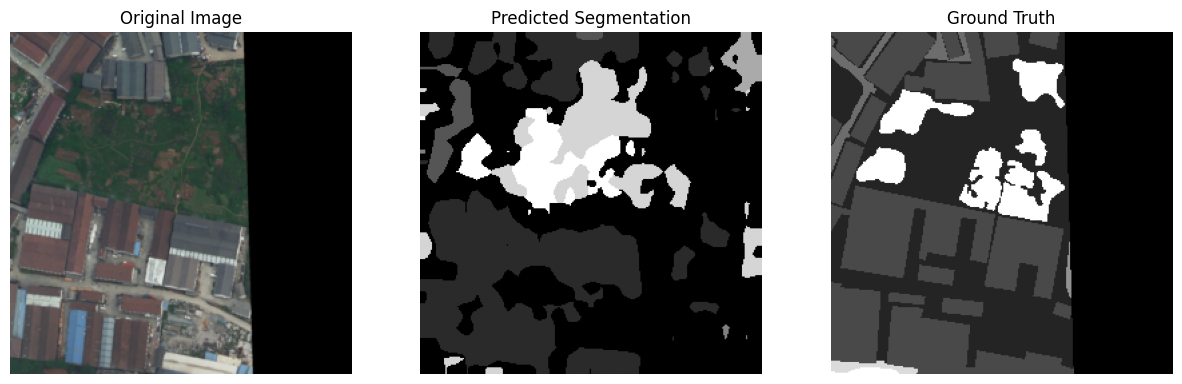

Params: 43.016 M


In [11]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    random_index = random.randint(0, len(val_dataset_urban) - 1)
    X, y = val_dataset_urban[random_index]
    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device)

    start = timer()
    output = model(X)
    end = timer()

    latency = end - start

flops = FlopCountAnalysis(model, X.clone())

print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
print(f"Average inference latency is {latency:.3f} seconds.")

# Converti output e ground truth per la visualizzazione
out = output.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
y_np = y.squeeze().cpu().numpy()  # Ground truth
X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

# Creazione della figura con tre immagini affiancate
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Immagine originale
axes[0].imshow(X_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predizione del modello
axes[1].imshow(out, cmap="gray")
axes[1].set_title("Predicted Segmentation")
axes[1].axis("off")

# Ground truth
axes[2].imshow(y_np, cmap="gray")
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.show()

# Conta i parametri del modello
params = sum(p.numel() for p in model.parameters())
print(f"Params: {params / 1e6:.3f} M")
